### Warning
This file contains in progress work on the model and may have weird bugs I haven't worked out yet.

In [5]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in /home/nels/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/nels/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100.0%


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
class VegetationDataset(Dataset):
    def __init__(self, image_path, mask_path, tranform=None):
        """Simple dataset for vegetation segmentation test."""
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = tranform
    
    def __len__(self):
        return 1
    
    def __rgb_to_class_mask(self, rgb_mask):
        """Convert the RGB mask to grayscale class mask."""
        height, width = rgb_mask.shape[:2]
        class_mask = np.zeros((height, width), dtype=np.uint8)

        # Black background
        black_mask  = (rgb_mask[:, :, 0] == 0) & (rgb_mask[:, :, 1] == 0) & (rgb_mask[:, :, 2] == 0)
        class_mask[black_mask] = 0

        # Green vegetation
        green_mask = (rgb_mask[:, :, 0] == 0) & (rgb_mask[:, :, 1] > 0) & (rgb_mask[:, :, 2] == 0)
        class_mask[green_mask] = 1

        # Blue vegetation
        blue_mask = (rgb_mask[:, :, 2] > rgb_mask[:,:,0]) & ((rgb_mask[:, :, 2])  > (rgb_mask[:, :, 1]))
        class_mask[blue_mask] = 2

        return class_mask
    
    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_path).convert('RGB')


        mask = Image.open(self.mask_path).convert('RGB')
        mask = np.array(mask)
        mask = self.__rgb_to_class_mask(mask)

        if self.transform:
            image = self.transform(image)

        return image, mask

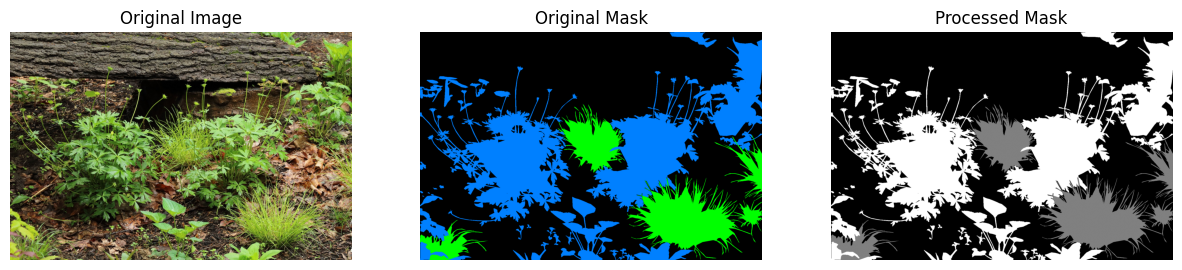

In [14]:
def show_dataset_sample(dataset, idx = 0):
    image_raw = Image.open(dataset.image_path).convert('RGB')
    mask_raw = Image.open(dataset.mask_path).convert('RGB')

    image, mask = dataset[idx]

    fig,axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_raw)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask_raw)
    axes[1].set_title('Original Mask')
    axes[1].axis('off')
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title('Processed Mask')
    axes[2].axis('off')
    plt.show()

Image_path = 'TestImage.jpg'
Mask_path = 'TestImageMask.png'
dataset = VegetationDataset(image_path=Image_path, mask_path=Mask_path, tranform=None)
show_dataset_sample(dataset)

In [ ]:
def test_pipeline():
    
    